# CytoData 2023 Hackathon

This is an example Notebook that presents how the hackathon data can be used.

In [ ]:
!pip install --upgrade numba
!pip install --upgrade umap-learn

In [ ]:
!pip install --user plotnine==0.12.3
!pip install numpy==1.22.4

In [ ]:
pip install --upgrade plotnine


In [ ]:
# Import used libraries
import os
import re
import random
import imageio
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sklearn.preprocessing
import sklearn.ensemble
import sklearn.metrics
import umap
import umap.plot
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
import xgboost as xgb


In [ ]:
from plotnine import *


In [3]:
# Define needed paths
root_path = Path('/').joinpath(*Path(os.getcwd()).parts[1:3])
img_path = root_path / 'images'
meta_path = root_path / 'metadata'
trainfeat_path = meta_path / 'cytodata2023_hackathon_features_train.csv'
testfeat_path = meta_path / 'cytodata2023_hackathon_features_test.csv'
trainmeta_path = meta_path / 'cytodata2023_hackathon_train.csv'
testmeta_path = meta_path / 'cytodata2023_hackathon_test.csv'
channels = ['1_AF488', '1_AF555', '1_AF647', '1_AF750', '1_DAPI', '2_AF647']

## Helper functions

In [4]:
def crop_rgb_tiles(img, cshape, rand_boxes=0):
    boxes = []
    if rand_boxes > 0:
        for i in range(rand_boxes):
            boxes.append((np.random.randint(0,img.shape[0]-cshape[0]), np.random.randint(0,img.shape[1]-cshape[1])))
    else:
        boxes = [(y,x) for x in range((img.shape[1]%cshape[1])//2, img.shape[1]-cshape[1], cshape[1])
                 for y in range((img.shape[0]%cshape[0])//2, img.shape[0]-cshape[0], cshape[0])]
    
    tiles = np.zeros((len(boxes),cshape[0],cshape[1],3), dtype=np.float32)
    for i,(sx,sy) in enumerate(boxes):
        cimg = img[sy:sy+cshape[0], sx:sx+cshape[1]]
        tiles[i,:,:,0] = cimg
        tiles[i,:,:,1] = cimg
        tiles[i,:,:,2] = cimg
    
    return tiles

## Read and check metadata and features

In [5]:
df_metadata_train = pd.read_csv(trainmeta_path)
df_features_train = pd.read_csv(trainfeat_path)

In [6]:
# Check metadata
df_metadata_train

,Slide,ROI number,PatientID,Location,Annotation Color,Progression,pT,Fuhrman
0,TMA-06,29,1,3,Blue2,1,3,2
1,TMA-09,66,2,2,Red1,1,2,3
2,TMA-07,67,4,3,Blue1,1,3,3
3,TMA-03,52,8,3,Blue2,0,3,2
4,TMA-06,27,1,2,Red2,1,3,2
...,...,...,...,...,...,...,...,...
237,TMA-04,127,68,2,Red1,0,1,1
238,TMA-01,11,58,2,Red1,0,1,2
239,TMA-03,124,34,3,Blue2,0,1,2
240,TMA-07,107,23,3,Blue1,1,1,2


In [7]:
df_features_train.shape
df_features_train.columns

Index(['Slide', 'ROI number', 'ObjectNumber', 'Intensity_MaxIntensity_Dapi',
       'Intensity_MaxIntensity_Epi', 'Intensity_MaxIntensity_Fap',
       'Intensity_MaxIntensity_Pdgfra', 'Intensity_MaxIntensity_Pdgfrb',
       'Intensity_MaxIntensity_Sma', 'Intensity_MeanIntensity_Dapi',
       'Intensity_MeanIntensity_Epi', 'Intensity_MeanIntensity_Fap',
       'Intensity_MeanIntensity_Pdgfra', 'Intensity_MeanIntensity_Pdgfrb',
       'Intensity_MeanIntensity_Sma', 'Intensity_MedianIntensity_Dapi',
       'Intensity_MedianIntensity_Epi', 'Intensity_MedianIntensity_Fap',
       'Intensity_MedianIntensity_Pdgfra', 'Intensity_MedianIntensity_Pdgfrb',
       'Intensity_MedianIntensity_Sma',
       'Intensity_UpperQuartileIntensity_Dapi',
       'Intensity_UpperQuartileIntensity_Epi',
       'Intensity_UpperQuartileIntensity_Fap',
       'Intensity_UpperQuartileIntensity_Pdgfra',
       'Intensity_UpperQuartileIntensity_Pdgfrb',
       'Intensity_UpperQuartileIntensity_Sma'],
      dtype='obj

In [8]:
# Check features
df_features_train.head(n=100000)

,Slide,ROI number,ObjectNumber,Intensity_MaxIntensity_Dapi,Intensity_MaxIntensity_Epi,Intensity_MaxIntensity_Fap,Intensity_MaxIntensity_Pdgfra,Intensity_MaxIntensity_Pdgfrb,Intensity_MaxIntensity_Sma,Intensity_MeanIntensity_Dapi,...,Intensity_MedianIntensity_Fap,Intensity_MedianIntensity_Pdgfra,Intensity_MedianIntensity_Pdgfrb,Intensity_MedianIntensity_Sma,Intensity_UpperQuartileIntensity_Dapi,Intensity_UpperQuartileIntensity_Epi,Intensity_UpperQuartileIntensity_Fap,Intensity_UpperQuartileIntensity_Pdgfra,Intensity_UpperQuartileIntensity_Pdgfrb,Intensity_UpperQuartileIntensity_Sma
0,TMA-01,11,1,0.032380,0.121126,0.021683,0.006744,0.025864,0.028534,0.020687,...,0.010697,0.004280,0.010742,0.004524,0.023926,0.073678,0.014145,0.004990,0.013458,0.005539
1,TMA-01,11,2,0.199237,0.850782,0.017700,0.006470,0.016800,0.007324,0.096314,...,0.007980,0.003830,0.007645,0.003494,0.127466,0.042306,0.009567,0.004273,0.008797,0.003876
2,TMA-01,11,3,0.099306,0.106569,0.027909,0.007019,0.015640,0.005707,0.049421,...,0.008995,0.004883,0.009651,0.003799,0.067735,0.055001,0.013588,0.005570,0.011788,0.004410
3,TMA-01,11,4,0.200458,0.146044,0.033417,0.008286,0.175113,0.119448,0.096978,...,0.009384,0.004288,0.068093,0.007568,0.123033,0.051465,0.013287,0.004776,0.099508,0.013188
4,TMA-01,11,5,0.166690,0.054231,0.105028,0.013413,0.226246,0.121859,0.080197,...,0.037697,0.005173,0.015709,0.005997,0.103346,0.027802,0.053239,0.006271,0.032040,0.010449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,TMA-02,33,1413,0.331945,0.506294,0.008957,0.005081,0.099458,0.007752,0.153500,...,0.004013,0.003494,0.010605,0.003998,0.200408,0.262585,0.004612,0.003891,0.016667,0.004765
99996,TMA-02,33,1414,0.105760,0.327901,0.009247,0.005142,0.120699,0.013230,0.066929,...,0.004776,0.003754,0.024392,0.004990,0.080446,0.227394,0.005489,0.004074,0.038422,0.006004
99997,TMA-02,33,1415,0.194507,0.466087,0.011704,0.006149,0.019318,0.007019,0.099209,...,0.005921,0.003876,0.009926,0.004112,0.122045,0.203315,0.007340,0.004425,0.012226,0.004654
99998,TMA-02,33,1416,0.118746,0.207996,0.006256,0.004227,0.076692,0.005890,0.069808,...,0.003159,0.002670,0.006317,0.003250,0.085718,0.048325,0.003555,0.002899,0.008553,0.003532


In [9]:
# Merge features and metadata, drop 'Annotation Color' columns
df_features_train = df_features_train.merge(df_metadata_train, on=['Slide','ROI number'], how='left')
df_features_train = df_features_train.drop('Annotation Color', axis=1)
df_features_train.head(n=1000)

,Slide,ROI number,ObjectNumber,Intensity_MaxIntensity_Dapi,Intensity_MaxIntensity_Epi,Intensity_MaxIntensity_Fap,Intensity_MaxIntensity_Pdgfra,Intensity_MaxIntensity_Pdgfrb,Intensity_MaxIntensity_Sma,Intensity_MeanIntensity_Dapi,...,Intensity_UpperQuartileIntensity_Epi,Intensity_UpperQuartileIntensity_Fap,Intensity_UpperQuartileIntensity_Pdgfra,Intensity_UpperQuartileIntensity_Pdgfrb,Intensity_UpperQuartileIntensity_Sma,PatientID,Location,Progression,pT,Fuhrman
0,TMA-01,11,1,0.032380,0.121126,0.021683,0.006744,0.025864,0.028534,0.020687,...,0.073678,0.014145,0.004990,0.013458,0.005539,58,2,0,1,2
1,TMA-01,11,2,0.199237,0.850782,0.017700,0.006470,0.016800,0.007324,0.096314,...,0.042306,0.009567,0.004273,0.008797,0.003876,58,2,0,1,2
2,TMA-01,11,3,0.099306,0.106569,0.027909,0.007019,0.015640,0.005707,0.049421,...,0.055001,0.013588,0.005570,0.011788,0.004410,58,2,0,1,2
3,TMA-01,11,4,0.200458,0.146044,0.033417,0.008286,0.175113,0.119448,0.096978,...,0.051465,0.013287,0.004776,0.099508,0.013188,58,2,0,1,2
4,TMA-01,11,5,0.166690,0.054231,0.105028,0.013413,0.226246,0.121859,0.080197,...,0.027802,0.053239,0.006271,0.032040,0.010449,58,2,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,TMA-01,11,996,0.125475,0.207919,0.013062,0.005371,0.012436,0.011307,0.065004,...,0.064439,0.008446,0.003609,0.008652,0.004105,58,2,0,1,2
996,TMA-01,11,997,0.216022,0.211856,0.027375,0.006668,0.105959,0.012665,0.116323,...,0.102621,0.012863,0.005295,0.013638,0.005875,58,2,0,1,2
997,TMA-01,11,998,0.204822,0.090898,0.018967,0.006088,0.149371,0.148379,0.120843,...,0.041196,0.008198,0.004822,0.061265,0.042679,58,2,0,1,2
998,TMA-01,11,999,0.208942,0.258595,0.020096,0.007492,0.062837,0.045533,0.112077,...,0.069787,0.013035,0.005234,0.013916,0.006104,58,2,0,1,2


In [10]:
selected_columns = df_features_train[['Slide', 'PatientID','ROI number','Location']]


In [68]:

desired_location = 1

# Filter the DataFrame to extract samples with the desired location
samples_at_desired_location = df_features_train[df_features_train['Location'] == desired_location]


In [69]:
# print(samples_at_desired_location)


In [70]:
print(selected_columns.loc[16150:16160])


        Slide  PatientID  ROI number  Location
16150  TMA-01         65          31         2
16151  TMA-01         65          31         2
16152  TMA-01         65          31         2
16153  TMA-01         65          31         2
16154  TMA-01         65          31         2
16155  TMA-01         65          31         2
16156  TMA-01         65          31         2
16157  TMA-01         65          31         2
16158  TMA-01         65          31         2
16159  TMA-01         65          31         2
16160  TMA-01         65          31         2


In [71]:
# Assuming you want to find the distinct values in the 'Column_Name' column
distinct_values =df_features_train['Location'].unique()

# Print the distinct values
print(distinct_values)

[2 3 1]


## Visualize images

Open a random core and visualize it.

In [72]:
# idx = df_metadata_train.sample(n=1).index[0]
# imgpaaths = img_path.glob(df_metadata_train.loc[idx,'Slide']+'*roi{:03d}*'.format(df_metadata_train.loc[idx,'ROI number']))
# imgpaths = [x for x in imgpaths]
# imgpaths.sort()

In [73]:
# # There should be 6 images to view
# rows = 2
# cols = 3
# fig,ax = plt.subplots(rows,cols,figsize=(14,9))
# for i,ipath in enumerate(imgpaths):
#     img = imageio.imread(ipath).astype(np.float32)
#     # Scale images from median (bg) to 0.998 quantile for visualization
#     intlow,inthigh = np.quantile(img,[0.5,0.998])
#     img = (img - intlow) / (inthigh-intlow)
#     img[img<0.0] = 0.0
#     img[img>1.0] = 1.0
#     img = (img * 255.0).astype(np.uint8)
#     ax[i//cols, i%cols].imshow(img, cmap='gray')
#     ax[i//cols, i%cols].set_title(ipath.name)

## Classical features

### Preprocess features

In [74]:
# Feature columns
# featcols = [x for x in df_features_train.columns if 'Intensity' in x]
# samples_at_desired_location
featcols = [x for x in samples_at_desired_location.columns if 'Intensity' in x]

In [75]:
# Feature columns
# featcols = [x for x in df_features_train.columns if 'Intensity' in x]
# samples_at_desired_location
featcols = [x for x in samples_at_desired_location.columns if 'Intensity' in x]

In [76]:
# drop NA
#prep_features = df_features_train.dropna()
# samples_at_desired_location
prep_features = samples_at_desired_location.dropna()

In [77]:
# Scale features
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(prep_features[featcols])
prep_features.loc[:,featcols] = scaler.transform(prep_features[featcols])
prep_features = prep_features.dropna()

In [78]:
prep_features.head()

,Slide,ROI number,ObjectNumber,Intensity_MaxIntensity_Dapi,Intensity_MaxIntensity_Epi,Intensity_MaxIntensity_Fap,Intensity_MaxIntensity_Pdgfra,Intensity_MaxIntensity_Pdgfrb,Intensity_MaxIntensity_Sma,Intensity_MeanIntensity_Dapi,...,Intensity_UpperQuartileIntensity_Epi,Intensity_UpperQuartileIntensity_Fap,Intensity_UpperQuartileIntensity_Pdgfra,Intensity_UpperQuartileIntensity_Pdgfrb,Intensity_UpperQuartileIntensity_Sma,PatientID,Location,Progression,pT,Fuhrman
9873,TMA-01,15,1,-1.161858,-0.925894,0.246173,-0.319289,-0.369235,-0.106825,-1.188731,...,-0.732129,0.005207,-0.375071,-0.266006,-0.146843,58,1,0,1,2
9874,TMA-01,15,2,-0.911232,-0.794795,-0.178819,-0.440142,-0.604893,-0.404286,-1.090626,...,-0.569427,-0.164533,-0.610823,-0.529588,-0.353604,58,1,0,1,2
9875,TMA-01,15,3,-0.063255,-0.980502,-0.067498,-0.294177,0.441789,-0.395409,-0.608619,...,-0.735830,0.016042,-0.360023,0.865909,-0.229873,58,1,0,1,2
9876,TMA-01,15,4,-0.541200,-0.923281,0.660198,-0.291038,-0.187549,0.344652,-0.855563,...,-0.680203,0.634511,-0.255941,-0.344138,-0.210336,58,1,0,1,2
9877,TMA-01,15,5,-1.069908,-0.931707,0.234109,-0.292608,-0.543466,-0.405836,-0.963432,...,-0.678293,0.638122,-0.204527,-0.458616,-0.334719,58,1,0,1,2


In [79]:
# Visualize 10% of the single-cell features of training data
mapper = umap.UMAP()
umap_sample = prep_features[featcols].sample(frac=0.1)
mapper.fit(umap_sample)

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

<Axes: >

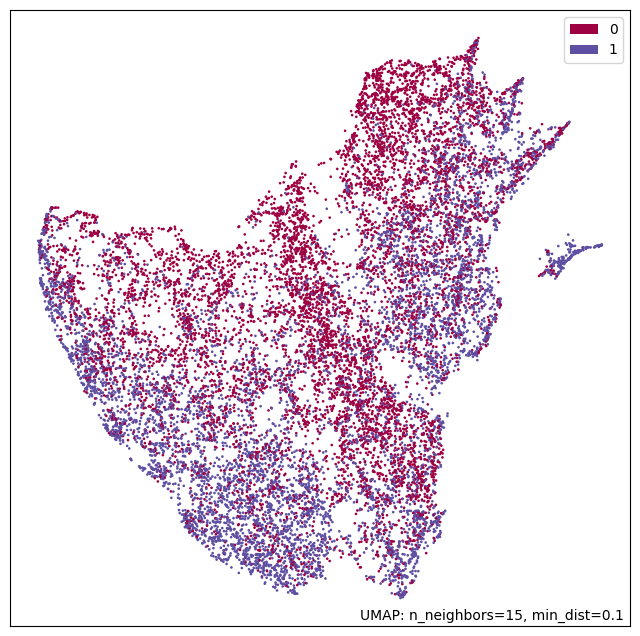

In [80]:
umap.plot.points(mapper, labels=prep_features.loc[umap_sample.index,'Progression'])


### Toy classification example

In [81]:
# Median features for each ROI

med_features = prep_features.groupby(['Slide','ROI number']).median().reset_index()

In [82]:
med_features.head()

,Slide,ROI number,ObjectNumber,Intensity_MaxIntensity_Dapi,Intensity_MaxIntensity_Epi,Intensity_MaxIntensity_Fap,Intensity_MaxIntensity_Pdgfra,Intensity_MaxIntensity_Pdgfrb,Intensity_MaxIntensity_Sma,Intensity_MeanIntensity_Dapi,...,Intensity_UpperQuartileIntensity_Epi,Intensity_UpperQuartileIntensity_Fap,Intensity_UpperQuartileIntensity_Pdgfra,Intensity_UpperQuartileIntensity_Pdgfrb,Intensity_UpperQuartileIntensity_Sma,PatientID,Location,Progression,pT,Fuhrman
0,TMA-01,15,1531.5,-0.159275,-0.679766,0.086596,-0.286330,-0.505703,-0.432045,-0.071620,...,-0.622338,0.192554,-0.319895,-0.442573,-0.329997,58.0,1.0,0.0,1.0,2.0
1,TMA-01,35,1730.5,0.178750,-0.796363,-0.030209,-0.195298,-0.390467,-0.230544,0.270329,...,-0.626322,0.070214,-0.124271,-0.368565,-0.273179,65.0,1.0,0.0,1.0,2.0
2,TMA-01,82,1542.5,-0.587334,-0.186105,-0.046660,-0.196868,-0.474341,-0.425634,-0.542494,...,-0.364110,-0.012399,-0.128660,-0.398930,-0.319089,17.0,1.0,0.0,1.0,2.0
3,TMA-01,137,1763.5,0.515020,0.136318,-0.063111,-0.253370,-0.521100,-0.426691,0.787572,...,-0.204691,-0.015107,-0.182582,-0.428977,-0.327230,38.0,1.0,0.0,1.0,3.0
4,TMA-01,146,2251.0,0.501850,-0.130549,-0.166754,-0.174895,-0.503272,-0.451350,0.813013,...,-0.218538,-0.085080,-0.074111,-0.404504,-0.331462,76.0,1.0,0.0,1.0,2.0


In [83]:
# Use single-cell features for classification
# Sample 30% to validation

X_train = med_features[featcols].sample(frac=0.7)
#y_train = med_features.loc[.index,'Progression']
y_train=med_features.loc[X_train.index,'Fuhrman']
X_test = med_features.loc[~med_features.index.isin(X_train.index),featcols]
y_test = med_features.loc[X_test.index,'Fuhrman']

In [84]:
# Fit and predict
model = sklearn.ensemble.RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [85]:
# # Evaluate
# accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
# #precision = sklearn.metrics.precision_score(y_test, y_pred)
# recall = sklearn.metrics.recall_score(y_test, y_pred)
f1_micro = sklearn.metrics.precision_score(y_test, y_pred, average='micro')
f1_macro = sklearn.metrics.precision_score(y_test, y_pred, average='macro')
f1_weighted = sklearn.metrics.precision_score(y_test, y_pred, average='weighted')
# print(y_pred)
# print(y_test)
#print(y_train)

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [86]:


# Evaluate
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred,)
precision = sklearn.metrics.precision_score(y_test, y_pred, average = "macro")
recall = sklearn.metrics.recall_score(y_test, y_pred, average = "macro")
f1 = sklearn.metrics.f1_score(y_test, y_pred, average = "macro")


/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [87]:
# Display class-wise F1 score
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
report = classification_report(y_test, y_pred)
print(report)
print(y_test)

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         3
         2.0       0.29      0.80      0.42         5
         3.0       0.00      0.00      0.00         7

    accuracy                           0.27        15
   macro avg       0.10      0.27      0.14        15
weighted avg       0.10      0.27      0.14        15

1     2.0
7     2.0
9     1.0
14    3.0
21    1.0
22    2.0
24    2.0
25    3.0
27    1.0
28    3.0
29    3.0
32    3.0
37    3.0
40    2.0
42    3.0
Name: Fuhrman, dtype: float64


/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [88]:
# print("Accuracy: {:.3f}".format(accuracy))
# print("Precision: {:.3f}".format(precision))
# print("Recall: {:.3f}".format(recall))
# print("F1: {:.3f}".format(f1))

In [89]:
print("F1 Micro:", f1_micro)
print("F1 Macro:", f1_macro)
print("F1 Weighted:", f1_weighted)


F1 Micro: 0.26666666666666666
F1 Macro: 0.09523809523809523
F1 Weighted: 0.09523809523809522


In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel


In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)
print(X_train.shape)

(34, 24)


In [92]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
feature_importances_loc = clf.feature_importances_
print("Feature importances:", feature_importances_loc)


Feature importances: [0.05093491 0.02919406 0.03302657 0.04819967 0.04329019 0.04500157
 0.04475479 0.03989276 0.0489985  0.03527248 0.04961585 0.04064809
 0.03359807 0.04527684 0.02694322 0.04429573 0.04029736 0.06057197
 0.05767711 0.03633852 0.03571006 0.03329922 0.0439185  0.03324397]


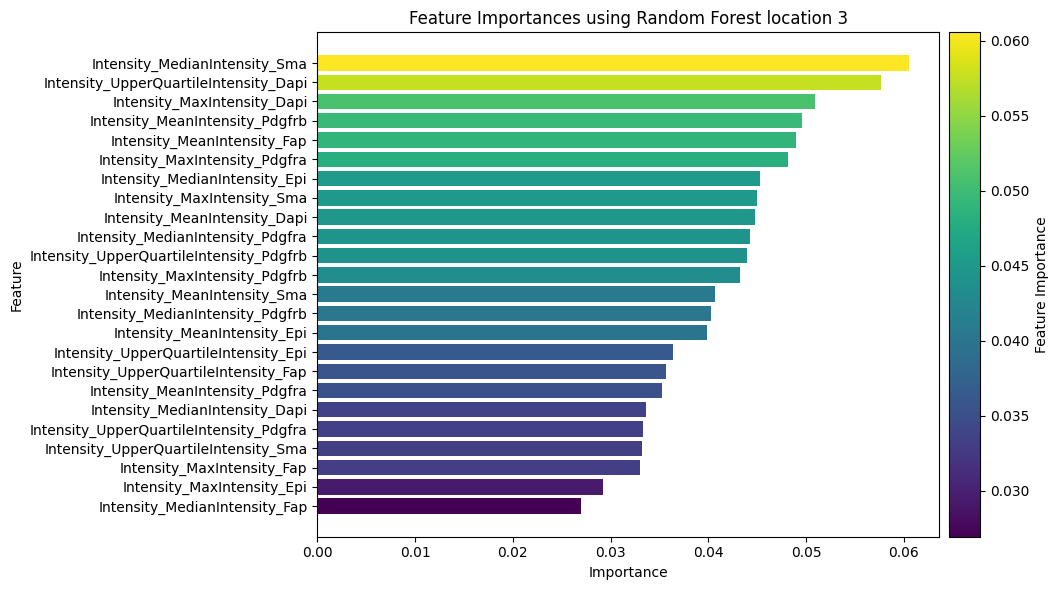

In [93]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Sort the feature importances in descending order
sorted_importances = np.array(sorted(feature_importances_loc, reverse=True))
#
original_columns = X_train.columns.tolist()


sorted_idx = np.argsort(feature_importances_loc)[::-1]
sorted_labels = [original_columns[i] for i in sorted_idx]


# Plotting feature importances using horizontal bars with colors
fig, ax = plt.subplots(figsize=(10, 6))

# Normalize the feature importances to the range [0, 1]
norm = Normalize(vmin=sorted_importances.min(), vmax=sorted_importances.max())

# Assign a color to each bar based on its normalized importance value using a colormap
colors = plt.cm.viridis(norm(sorted_importances))

# Create horizontal bars with the assigned colors
bars = ax.barh(range(X_train.shape[1]), sorted_importances, align='center', color=colors)

# Use the sorted labels for the y-ticks
ax.set_yticks(range(X_train.shape[1]))
ax.set_yticklabels(sorted_labels)
ax.set_ylabel('Feature')
ax.set_xlabel('Importance')
ax.set_title('Feature Importances using Random Forest location 3')
plt.tight_layout()

# Create space for the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Set up colorbar
sm = ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation="vertical", label="Feature Importance")

ax.invert_yaxis()  # This will show the most important feature at the top
plt.show()


In [94]:
print(sorted_importances)
print(sorted_labels)

[0.06057197 0.05767711 0.05093491 0.04961585 0.0489985  0.04819967
 0.04527684 0.04500157 0.04475479 0.04429573 0.0439185  0.04329019
 0.04064809 0.04029736 0.03989276 0.03633852 0.03571006 0.03527248
 0.03359807 0.03329922 0.03324397 0.03302657 0.02919406 0.02694322]
['Intensity_MedianIntensity_Sma', 'Intensity_UpperQuartileIntensity_Dapi', 'Intensity_MaxIntensity_Dapi', 'Intensity_MeanIntensity_Pdgfrb', 'Intensity_MeanIntensity_Fap', 'Intensity_MaxIntensity_Pdgfra', 'Intensity_MedianIntensity_Epi', 'Intensity_MaxIntensity_Sma', 'Intensity_MeanIntensity_Dapi', 'Intensity_MedianIntensity_Pdgfra', 'Intensity_UpperQuartileIntensity_Pdgfrb', 'Intensity_MaxIntensity_Pdgfrb', 'Intensity_MeanIntensity_Sma', 'Intensity_MedianIntensity_Pdgfrb', 'Intensity_MeanIntensity_Epi', 'Intensity_UpperQuartileIntensity_Epi', 'Intensity_UpperQuartileIntensity_Fap', 'Intensity_MeanIntensity_Pdgfra', 'Intensity_MedianIntensity_Dapi', 'Intensity_UpperQuartileIntensity_Pdgfra', 'Intensity_UpperQuartileIntensi

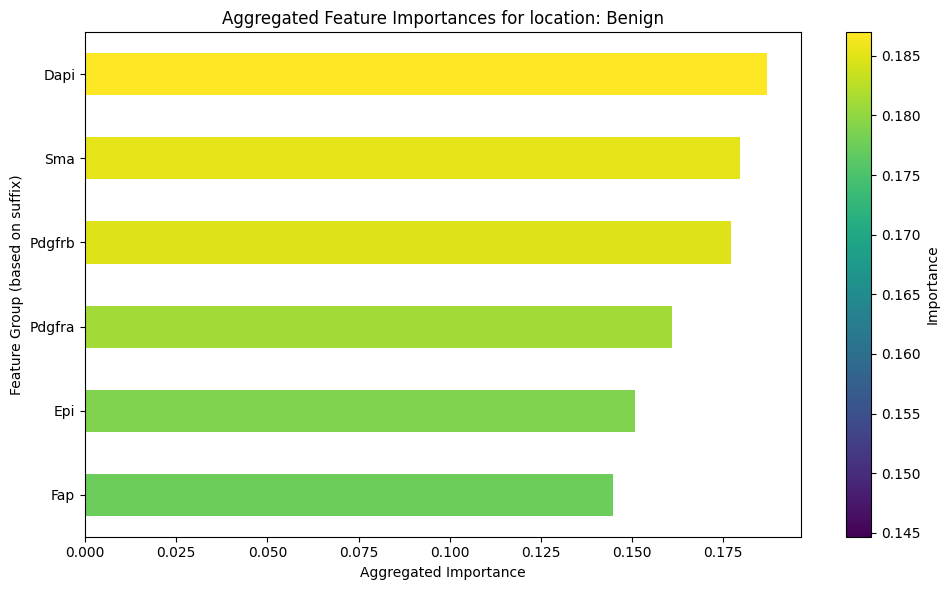

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data to emulate your input
original_columns = sorted_labels
feature_importances_loc = sorted_importances

# Create a DataFrame with the features and their importances
df = pd.DataFrame({'Feature': original_columns, 'Importance': feature_importances_loc})

# Extract the suffix after the last underscore
df['Suffix'] = df['Feature'].str.split('_').str[-1]

# Aggregate the importances by the suffix and sort in descending order
aggregated_importances = df.groupby('Suffix')['Importance'].sum().sort_values(ascending=False)

# Plotting the aggregated feature importances
fig, ax = plt.subplots(figsize=(10, 6))

cmap = plt.get_cmap("viridis")
colors = cmap(aggregated_importances.values / aggregated_importances.max())


# Using the viridis colormap to color bars based on their values

aggregated_importances.plot(kind='barh', ax=ax, color=colors)

ax.set_ylabel('Feature Group (based on suffix)')
ax.set_xlabel('Aggregated Importance')
ax.set_title(f'Aggregated Feature Importances for location: Benign')

ax.invert_yaxis()  # To display the bars in descending order

# Display a colorbar to the right of the plot
norm = plt.Normalize(aggregated_importances.min(), aggregated_importances.max())
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical')
cbar.set_label('Importance')

plt.tight_layout()
plt.show()


#save_path = "/Users/Sitani/Documents/aggregatedimportanceloc3.png"


fig.savefig("aggregatedimportanceloc1.png", dpi=300, bbox_inches='tight')



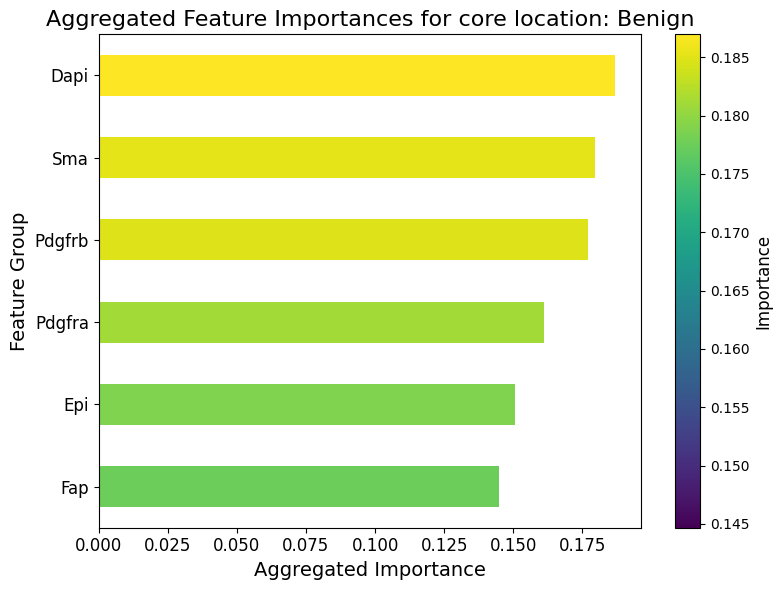

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data to emulate your input
original_columns = sorted_labels
feature_importances_loc = sorted_importances

# Create a DataFrame with the features and their importances
df = pd.DataFrame({'Feature': original_columns, 'Importance': feature_importances_loc})

# Extract the suffix after the last underscore
df['Suffix'] = df['Feature'].str.split('_').str[-1]

# Aggregate the importances by the suffix and sort in descending order
aggregated_importances = df.groupby('Suffix')['Importance'].sum().sort_values(ascending=False)

# Plotting the aggregated feature importances
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the width here

cmap = plt.get_cmap("viridis")
colors = cmap(aggregated_importances.values / aggregated_importances.max())

# Using the viridis colormap to color bars based on their values
aggregated_importances.plot(kind='barh', ax=ax, color=colors)

# Adjusting font sizes
ax.set_ylabel('Feature Group', fontsize=14)
ax.set_xlabel('Aggregated Importance', fontsize=14)
ax.set_title(f'Aggregated Feature Importances for core location: Benign', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust tick label size

ax.invert_yaxis()  # To display the bars in descending order

# Display a colorbar to the right of the plot
norm = plt.Normalize(aggregated_importances.min(), aggregated_importances.max())
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical')
cbar.set_label('Importance', fontsize=12)

plt.tight_layout()
plt.show()

fig.savefig("aggregatedimportanceloc2.png", dpi=300, bbox_inches='tight')


In [ ]:

from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression



In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.ensemble import VotingClassifier

thresholds = np.linspace(0, aggregated_importances.max(), 50)  # 50 values between 0 and max importance
f1_scores = []
print(thresholds)
for threshold in thresholds[:-1]:
    # Filter features based on threshold
    important_suffixes = aggregated_importances[aggregated_importances > threshold].index.tolist()
    important_features = [col for col in X_train.columns if col.split('_')[-1] in important_suffixes]
    
    X_train_filtered = X_train[important_features]
    X_test_filtered = X_test[important_features]
    #print(X_train_filtered)
    print(threshold)
    # Train the RandomForest classifier
    rf_clf = RandomForestClassifier(n_estimators=100)
    rf_clf.fit(X_train_filtered, y_train)
    
    # Predict on a validation/test set
    y_pred = rf_clf.predict(X_test_filtered)
    
    # Compute F1 score and store
    f1 = f1_score(y_test, y_pred, average='weighted')  # Adjust based on your problem (binary/multi-class)
    f1_scores.append(f1)



In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds[:-1], f1_scores, '-o')
plt.title("Threshold vs. Average F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Average F1 Score")
plt.grid(True)
plt.show()


In [ ]:
best_index = np.argmax(f1_scores)


In [ ]:
best_threshold = thresholds[best_index]


In [ ]:

# Identify the important suffixes using the best threshold
important_suffixes = aggregated_importances[aggregated_importances > best_threshold].index.tolist()

# Get the important features from the train dataset using the identified suffixes
important_features = [col for col in X_train.columns if col.split('_')[-1] in important_suffixes]

# 1. Filter the train and test datasets
X_train_best_features = X_train[important_features]
X_test_best_features = X_test[important_features]

# 2. Train the RandomForest classifier
rf_clf_best = RandomForestClassifier(n_estimators=100)
rf_clf_best.fit(X_train_best_features, y_train)

# 3. Make predictions on the test set
y_pred_best = rf_clf_best.predict(X_test_best_features)


In [ ]:
report = classification_report(y_test, y_pred)
print(report)
print(y_test)

## DL features with pretrained network

In [ ]:
input_shape = (256,256,3)
dl_featcols = ['feat_{}'.format(x) for x in range(2048)]

In [ ]:
# Check channel distributions for preprocessing using 20% of images (NOTE: mixes train and test images)
ch_dist = {}
for ch in channels:
    files = [x for x in img_path.glob(f'*{ch}*')]
    files = random.choices(files, k=int(len(files)*0.2))
    dist = np.zeros((len(files),2), dtype=np.float32)
    for i,fpath in tqdm(enumerate(files)):
        img = imageio.imread(fpath)
        dist[i,0] = img.mean()
        dist[i,1] = img.std()
    ch_dist[ch] = (np.mean(dist[:,0]), np.mean(dist[:,1]))

In [ ]:
ch_dist

In [ ]:
# # Load pretrained model
# resnet = tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape, weights='imagenet', pooling='max')
# resnet.summary()

In [ ]:
# Load pretrained model
resnet = tf.keras.applications.ResNet101(include_top=False, input_shape=input_shape, weights='imagenet', pooling='max')
resnet.summary()

In [ ]:
# Extract features separately for each image, sample 64 boxes per image, not optimized as uses GPU only for the prediction
num_boxes = 64
df_dlrois = []
for idx,row in tqdm(df_metadata_train.iterrows()):
    ipaths = img_path.glob(row['Slide']+'*roi{:03d}*'.format(row['ROI number']))
    pat = re.compile('{}_(\d_\w+)_roi{:03d}.png'.format(row['Slide'],row['ROI number']))
    df_dlchs = []
    for ipath in ipaths:
        ch = pat.match(ipath.name).group(1)
        img = imageio.imread(ipath).astype(np.float32)
        img = (img - ch_dist[ch][0]) / ch_dist[ch][1]
        tiles = crop_rgb_tiles(img, input_shape, rand_boxes=num_boxes)
        feat = np.zeros((tiles.shape[0],2048), dtype=np.float32)
        feat = resnet.predict(tiles)
        df_dlroi = pd.DataFrame(columns=[ch+'_'+x for x in dl_featcols], data=feat)
        df_dlchs.append(df_dlroi)
    df_dlch = pd.concat(df_dlchs, axis=1)
    df_dlch['Slide'] = row['Slide']
    df_dlch['ROI number'] = row['ROI number']
    df_dlrois.append(df_dlch)
df_dlfeat = pd.concat(df_dlrois)

### Preprocess and visualize

In [ ]:
dl_featcols = [x for x in df_dlfeat.columns if 'feat' in x]
df_dlfeat

In [ ]:
dlfeat = df_dlfeat.copy()
dlfeat = dlfeat.merge(df_metadata_train, on=['Slide','ROI number'], how='left').drop('Annotation Color', axis=1)
# Scale features
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(dlfeat[dl_featcols])
dlfeat.loc[:,dl_featcols] = scaler.transform(dlfeat[dl_featcols])
dlfeat = dlfeat.dropna()

In [ ]:
train_feat = dlfeat.sample(frac=0.7)
test_feat = dlfeat.loc[~dlfeat.index.isin(train_feat.index),:]

In [ ]:
# Visualize single-cell features of the training data
umap_sample = train_feat.sample(frac=0.1)
mapper = umap.UMAP()
mapper.fit(umap_sample[dl_featcols])

In [ ]:
umap.plot.points(mapper, labels=umap_sample['Progression'])

### Toy classification with DL features

In [ ]:
train_feat

In [ ]:
med_train_feat = train_feat.groupby(["Slide","ROI number"]).median().reset_index()
med_test_feat = test_feat.groupby(["Slide","ROI number"]).median().reset_index()

In [ ]:
# Use single-cell features for classification
X_train = med_train_feat[dl_featcols]
y_train = med_train_feat['Progression']
X_test = med_test_feat[dl_featcols]
y_test = med_test_feat['Progression']

In [ ]:
# Fit and predict
model = sklearn.ensemble.RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
# Evaluate
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
precision = sklearn.metrics.precision_score(y_test, y_pred)
recall = sklearn.metrics.recall_score(y_test, y_pred)

In [ ]:
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))